# Preparation for 9.9 campaign for SPP Wallet

**Data required:**

1. Peak no of txns created in 1 sec on 8.8, 7.7 (Please include the peak TPS timestamp also)
2. Peak no of payments that moved from 'Initial' status to 'Payment_Init' status in 1 sec on 8.8, 7.7 (Please include the peak TPS timestamp also)
3. Peak no of payments that moved from 'Payment_Init' status to 'User_Processing' status in 1 sec on 8.8, 7.7 (Please include the peak TPS timestamp also)
4. Peak no of payments that moved from 'User_Processing' status to 'Success/Failed' status in 1 sec on 8.8, 7.7 (Please include the peak TPS timestamp also)

**Method:**

1. Find peak transactions per second (TPS) and peak payment per second（PPS)


In [2]:
import time
from functools import reduce
import pyspark
import pandas as pd

regions = {
    "PH": {"Timezone": 8, "Version": 1},
    "SG": {"Timezone": 8, "Version": 1},
    "MY": {"Timezone": 8, "Version": 2},
    "ID": {"Timezone": 7, "Version": 2},
    "TH": {"Timezone": 7, "Version": 2},
    "VN": {"Timezone": 7, "Version": 2}
} 

for k, v in regions.items():
    print(k, v['Timezone'], v['Version'])

PH 8 1
SG 8 1
MY 8 2
ID 7 2
TH 7 2
VN 7 2


### 1.1 Payment Per Seconds (PPS)

In [15]:
%%time

# PPS

regions = {
    "PH": {"Timezone": 8, "Version": 1},
    "SG": {"Timezone": 8, "Version": 1},
    "MY": {"Timezone": 8, "Version": 2},
    "ID": {"Timezone": 7, "Version": 2},
    "TH": {"Timezone": 7, "Version": 2},
    "VN": {"Timezone": 7, "Version": 2}
} 

sdfArr = []

for k, v in regions.items():
    if v['Version'] == 1:
        tableVersionVariable = "_"
    elif v['Version'] == 2:
        tableVersionVariable = "_v2_"
    print(f'Working on: {k}')
    
    sqlFile = '''
    WITH base_table AS (
        SELECT 
            '{0}' AS country,
            e.channel_id, 
            e.description as channel_name, 
            b.ctime + (({1}-8)*3600) as ctime,
            to_timestamp(b.ctime + (({1}-8)*3600)) as timestamp,
            COUNT(distinct b.payment_id) as payment_no
        FROM shopee.shopee_payment_module_transaction_{0}_db__transaction{2}tab a
        LEFT JOIN shopee.shopee_payment_module_payment_{0}_db__payment{2}tab b
        ON a.transaction_id = b.transaction_id
        LEFT JOIN shopee.shopee_payment_module_{0}_db__payment_channel_tab e
        ON b.channel_id = e.channel_id
        WHERE 
            b.payment_type = 4 --payment type = PAYMENT
            AND e.country = '{0}'
            -- AND bitwise_and(e.flag, 64) = 0
            AND b.channel_id IN (8001400, 2001400, 4001400, 1001400, 7001800, 5001800)
            AND DATE(from_unixtime(b.ctime + (({1}-8)*3600))) IN (DATE('2021-07-07'), DATE('2021-08-08'))
        GROUP BY 1,2,3,4,5
    ), max_payment AS (
        SELECT 
            country, 
            DATE(from_unixtime(ctime)) AS date, 
            channel_id, 
            channel_name, 
            max(payment_no) as max_payment_no
        FROM base_table
        GROUP BY 1,2,3,4
    ), max_payment_ts AS (
        SELECT 
            a.*, b.timestamp
        FROM max_payment a
        JOIN base_table b 
        ON 
            a.country = b.country 
            AND a.channel_id = b.channel_id
            AND a.channel_name = b.channel_name
            AND a.max_payment_no = b.payment_no
            AND a.date = DATE(from_unixtime(b.ctime))
        ORDER BY date
    )
    
    SELECT * FROM max_payment_ts
    '''
    start_time = time.time()
    sqlFile = sqlFile.format(k, v['Timezone'], tableVersionVariable)
    sdf = spark.sql(sqlFile)
#     regions[k]['sdf'] = sdf 
    sdf.cache()
    sdfArr.append(sdf)
    print(f'Query took: {time.time() - start_time} seconds.')
    
sdf_union = reduce(pyspark.sql.DataFrame.unionAll, sdfArr)
sdf_union.show()
sdf_union.toPandas().to_csv('max_pps.csv', index=False)

Working on: PH
Query took: 0.25299072265625 seconds.
Working on: SG
Query took: 0.26169776916503906 seconds.
Working on: MY
Query took: 0.2886343002319336 seconds.
Working on: ID
Query took: 0.26749205589294434 seconds.
Working on: TH
Query took: 0.2474665641784668 seconds.
Working on: VN
Query took: 0.24383807182312012 seconds.
+-------+----------+----------+-------------------+--------------+-------------------+
|country|      date|channel_id|       channel_name|max_payment_no|          timestamp|
+-------+----------+----------+-------------------+--------------+-------------------+
|     PH|2021-07-07|   4001400|Shopee Wallet V2 PH|           357|2021-07-07 00:06:45|
|     PH|2021-08-08|   4001400|Shopee Wallet V2 PH|           370|2021-08-08 00:01:47|
|     SG|2021-07-07|   1001400|Shopee Wallet V2 SG|           255|2021-07-07 13:30:11|
|     SG|2021-08-08|   1001400|Shopee Wallet V2 SG|           232|2021-08-08 18:20:08|
|     MY|2021-07-07|   2001400|Shopee Wallet V2 MY|         

In [23]:
%%time

# PPS - history by seconds

regions = {
    "PH": {"Timezone": 8, "Version": 1},
    "SG": {"Timezone": 8, "Version": 1},
    "MY": {"Timezone": 8, "Version": 2},
    "ID": {"Timezone": 7, "Version": 2},
    "TH": {"Timezone": 7, "Version": 2},
    "VN": {"Timezone": 7, "Version": 2}
} 

sdfArr = []

for k, v in regions.items():
    if v['Version'] == 1:
        tableVersionVariable = "_"
    elif v['Version'] == 2:
        tableVersionVariable = "_v2_"
    print(f'Working on: {k}')
    
    sqlFile = '''
    WITH base_table AS (
        SELECT 
            '{0}' AS country,
            e.channel_id, 
            e.description as channel_name, 
            b.ctime + (({1}-8)*3600) as ctime,
            to_timestamp(b.ctime + (({1}-8)*3600)) as timestamp,
            COUNT(distinct b.payment_id) as payment_no
        FROM shopee.shopee_payment_module_transaction_{0}_db__transaction{2}tab a
        LEFT JOIN shopee.shopee_payment_module_payment_{0}_db__payment{2}tab b
        ON a.transaction_id = b.transaction_id
        LEFT JOIN shopee.shopee_payment_module_{0}_db__payment_channel_tab e
        ON b.channel_id = e.channel_id
        WHERE 
            b.payment_type = 4 --payment type = PAYMENT
            AND e.country = '{0}'
            -- AND bitwise_and(e.flag, 64) = 0
            AND b.channel_id IN (8001400, 2001400, 4001400, 1001400, 7001800, 5001800)
            AND DATE(from_unixtime(b.ctime + (({1}-8)*3600))) IN (DATE('2021-07-07'), DATE('2021-08-08'))
        GROUP BY 1,2,3,4,5
    )
    
    SELECT 
        country,
        DATE(from_unixtime(ctime)) AS date,
        timestamp,
        channel_id,
        channel_name,
        payment_no
    FROM base_table
    ORDER BY 1,2,3
    '''
    start_time = time.time()
    sqlFile = sqlFile.format(k, v['Timezone'], tableVersionVariable)
    sdf = spark.sql(sqlFile)
    sdf.cache()
    sdfArr.append(sdf)
    print(f'Query took: {time.time() - start_time} seconds.')
    
sdf_union = reduce(pyspark.sql.DataFrame.unionAll, sdfArr)
sdf_union.show()
sdf_union.toPandas().to_csv('max_pps_history_bySeconds.csv', index=False)

Working on: PH
Query took: 0.2305619716644287 seconds.
Working on: SG
Query took: 0.19729042053222656 seconds.
Working on: MY
Query took: 1.2746615409851074 seconds.
Working on: ID
Query took: 0.20450067520141602 seconds.
Working on: TH
Query took: 0.2106337547302246 seconds.
Working on: VN
Query took: 0.17435073852539062 seconds.
+-------+----------+-------------------+----------+-------------------+----------+
|country|      date|          timestamp|channel_id|       channel_name|payment_no|
+-------+----------+-------------------+----------+-------------------+----------+
|     PH|2021-07-07|2021-07-07 00:00:00|   4001400|Shopee Wallet V2 PH|        10|
|     PH|2021-07-07|2021-07-07 00:00:01|   4001400|Shopee Wallet V2 PH|        16|
|     PH|2021-07-07|2021-07-07 00:00:02|   4001400|Shopee Wallet V2 PH|        80|
|     PH|2021-07-07|2021-07-07 00:00:03|   4001400|Shopee Wallet V2 PH|       199|
|     PH|2021-07-07|2021-07-07 00:00:04|   4001400|Shopee Wallet V2 PH|       232|
|  

In [70]:
# Read 
df = pd.read_csv('max_pps_history_bySeconds.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.time
df[(df['country']=='PH') & (df['date']=='2021-07-07')][['timestamp', 'payment_no']].set_index('timestamp')
country_arr = df['country'].unique().tolist()

for i, country in enumerate(tuple(country_arr)):
    for j, date in enumerate(('2021-07-07', '2021-08-08')):
        print(i, country, j, date)

0 PH 0 2021-07-07
0 PH 1 2021-08-08
1 SG 0 2021-07-07
1 SG 1 2021-08-08
2 MY 0 2021-07-07
2 MY 1 2021-08-08
3 ID 0 2021-07-07
3 ID 1 2021-08-08
4 TH 0 2021-07-07
4 TH 1 2021-08-08
5 VN 0 2021-07-07
5 VN 1 2021-08-08


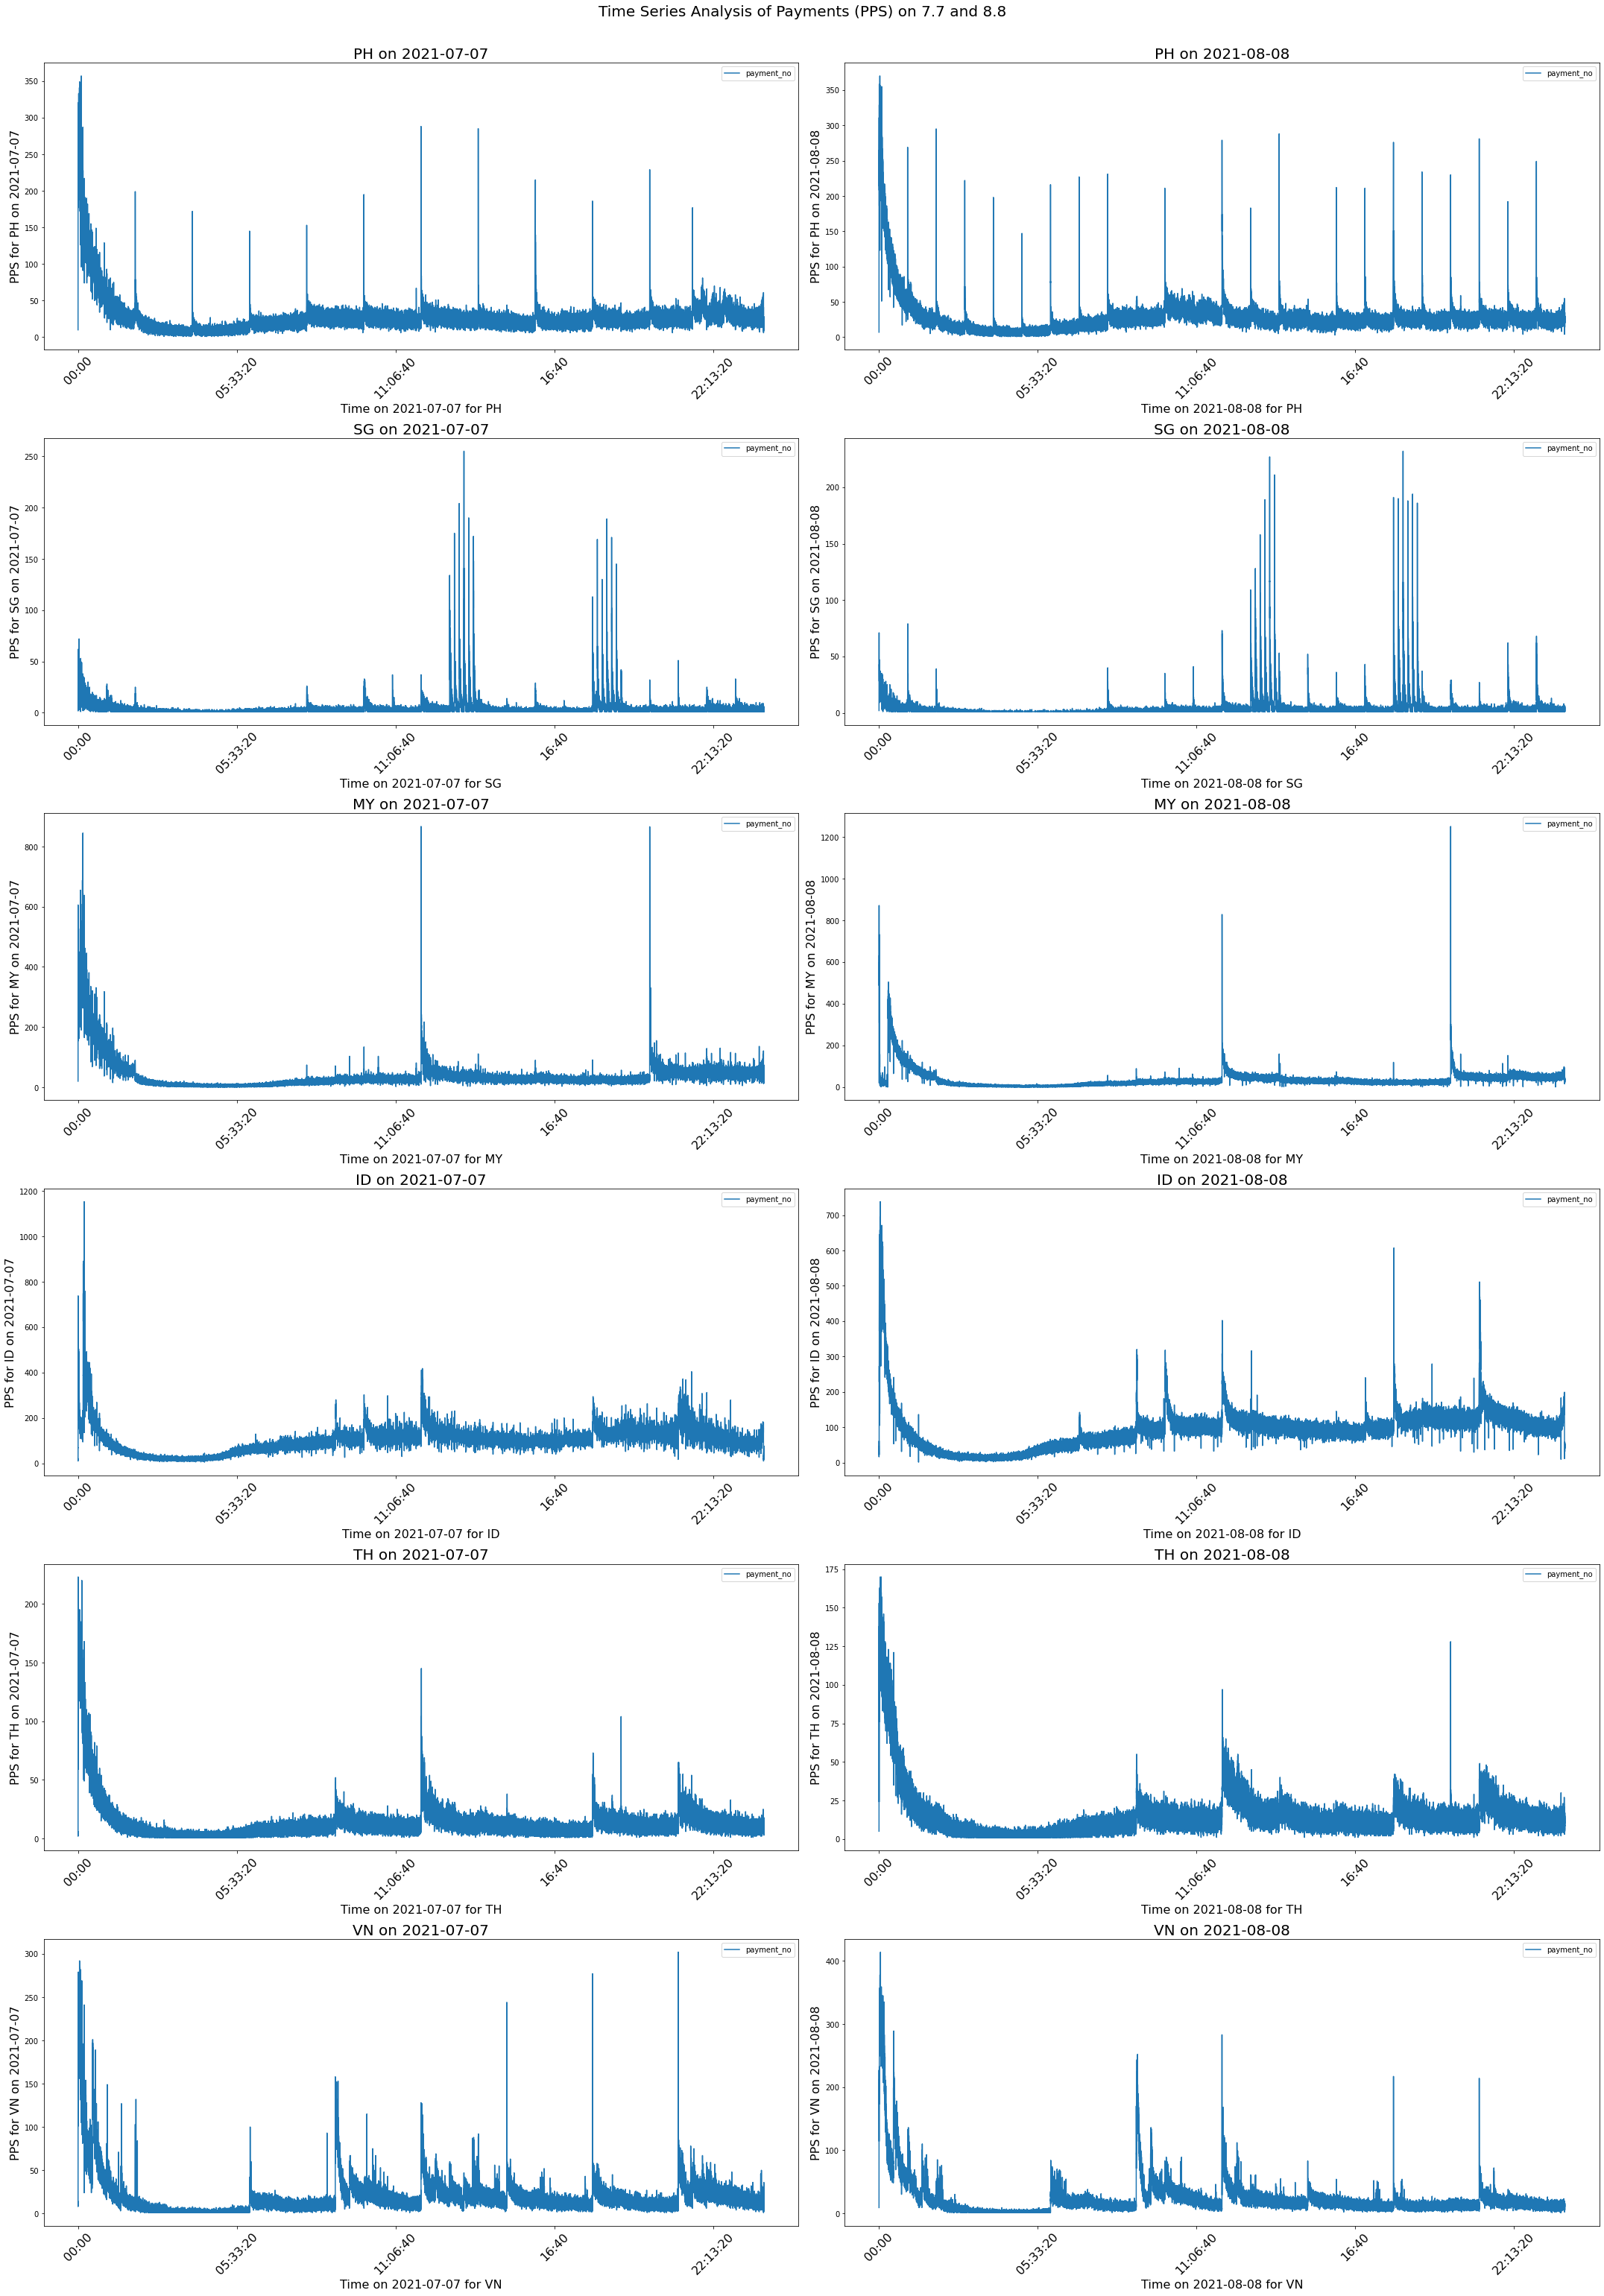

In [6]:
# Plot 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(6,2)

for i, country in enumerate(tuple(country_arr)):
    for j, date in enumerate(('2021-07-07', '2021-08-08')):

        df[(df['country']==country) & (df['date']==date)][['timestamp', 'payment_no']].set_index('timestamp').\
            plot(figsize=(30,45), ax = ax[i,j], x_compat=True)
        ax[i,j].set_ylabel(f'PPS for {country} on {date}', fontsize = 16)
        ax[i,j].set_xlabel(f'Time on {date} for {country}', fontsize = 16)
        ax[i,j].set_title(f'{country} on {date}', fontsize=20)
        ax[i,j].xaxis.set_tick_params(rotation = 45, labelsize=16)
        
#         hours = mdates.HourLocator(interval = 1)
#         h_fmt = mdates.DateFormatter('%H:%M:%S')
#         ax[i,j].xaxis.set_major_locator(hours)
#         ax[i,j].xaxis.set_major_formatter(h_fmt)

# fig.autofmt_xdate()
fig.suptitle(f'Time Series Analysis of Payments (PPS) on 7.7 and 8.8', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.975])

### 1.2 Transactions Per Seconds (TPS)

In [16]:
%%time

# TPS

regions = {
    "PH": {"Timezone": 8, "Version": 1},
    "SG": {"Timezone": 8, "Version": 1},
    "MY": {"Timezone": 8, "Version": 2},
    "ID": {"Timezone": 7, "Version": 2},
    "TH": {"Timezone": 7, "Version": 2},
    "VN": {"Timezone": 7, "Version": 2}
} 

sdfArr = []

for k, v in regions.items():
    if v['Version'] == 1:
        tableVersionVariable = "_"
    elif v['Version'] == 2:
        tableVersionVariable = "_v2_"
    print(f'Working on: {k}')
    
    sqlFile = '''
    WITH base_table AS (
        SELECT 
            '{0}' AS country,
            e.channel_id, 
            e.description as channel_name, 
            a.ctime + (({1}-8)*3600) as ctime,
            to_timestamp(a.ctime + (({1}-8)*3600)) as timestamp,
            COUNT(distinct a.transaction_id) as transaction_no
        FROM shopee.shopee_payment_module_transaction_{0}_db__transaction{2}tab a
        LEFT JOIN shopee.shopee_payment_module_payment_{0}_db__payment{2}tab b
        ON a.transaction_id = b.transaction_id
        LEFT JOIN shopee.shopee_payment_module_{0}_db__payment_channel_tab e
        ON b.channel_id = e.channel_id
        WHERE 
            b.payment_type = 4 --payment type = PAYMENT
            AND e.country = '{0}'
            -- AND bitwise_and(e.flag, 64) = 0
            AND b.channel_id IN (8001400, 2001400, 4001400, 1001400, 7001800, 5001800)
            AND DATE(from_unixtime(a.ctime + (({1}-8)*3600))) IN (DATE('2021-07-07'), DATE('2021-08-08'))
        GROUP BY 1,2,3,4,5
    ), max_txn AS (
        SELECT 
            country, 
            DATE(from_unixtime(ctime)) AS date, 
            channel_id, 
            channel_name, 
            max(transaction_no) as max_transaction_no
        FROM base_table
        GROUP BY 1,2,3,4
    ), max_txn_ts AS (
        SELECT 
            a.*, b.timestamp
        FROM max_txn a
        JOIN base_table b 
        ON 
            a.country = b.country 
            AND a.channel_id = b.channel_id
            AND a.channel_name = b.channel_name
            AND a.max_transaction_no = b.transaction_no
    )
    
    SELECT * FROM max_txn_ts
    '''
    start_time = time.time()
    sqlFile = sqlFile.format(k, v['Timezone'], tableVersionVariable)
    sdf = spark.sql(sqlFile)
    sdf.cache()
    sdfArr.append(sdf)
    print(f'Query took: {time.time() - start_time} seconds.')
    
sdf_union = reduce(pyspark.sql.DataFrame.unionAll, sdfArr)
sdf_union.show()
sdf_union.toPandas().to_csv('max_tps.csv', index=False)

Working on: PH
Query took: 0.8730833530426025 seconds.
Working on: SG
Query took: 0.3135523796081543 seconds.
Working on: MY
Query took: 0.31247639656066895 seconds.
Working on: ID
Query took: 0.2951648235321045 seconds.
Working on: TH
Query took: 0.3597548007965088 seconds.
Working on: VN
Query took: 0.33810949325561523 seconds.
+-------+----------+----------+-------------------+------------------+-------------------+
|country|      date|channel_id|       channel_name|max_transaction_no|          timestamp|
+-------+----------+----------+-------------------+------------------+-------------------+
|     PH|2021-08-08|   4001400|Shopee Wallet V2 PH|               384|2021-08-08 00:05:31|
|     PH|2021-07-07|   4001400|Shopee Wallet V2 PH|               357|2021-07-07 00:03:28|
|     SG|2021-08-08|   1001400|Shopee Wallet V2 SG|               231|2021-08-08 18:20:08|
|     SG|2021-07-07|   1001400|Shopee Wallet V2 SG|               276|2021-07-07 13:30:11|
|     MY|2021-08-08|   2001400|

In [24]:
%%time

# TPS - history by seconds

regions = {
    "PH": {"Timezone": 8, "Version": 1},
    "SG": {"Timezone": 8, "Version": 1},
    "MY": {"Timezone": 8, "Version": 2},
    "ID": {"Timezone": 7, "Version": 2},
    "TH": {"Timezone": 7, "Version": 2},
    "VN": {"Timezone": 7, "Version": 2}
} 

sdfArr = []

for k, v in regions.items():
    if v['Version'] == 1:
        tableVersionVariable = "_"
    elif v['Version'] == 2:
        tableVersionVariable = "_v2_"
    print(f'Working on: {k}')
    
    sqlFile = '''
    WITH base_table AS (
        SELECT 
            '{0}' AS country,
            e.channel_id, 
            e.description as channel_name, 
            a.ctime + (({1}-8)*3600) as ctime,
            to_timestamp(a.ctime + (({1}-8)*3600)) as timestamp,
            COUNT(distinct a.transaction_id) as transaction_no
        FROM shopee.shopee_payment_module_transaction_{0}_db__transaction{2}tab a
        LEFT JOIN shopee.shopee_payment_module_payment_{0}_db__payment{2}tab b
        ON a.transaction_id = b.transaction_id
        LEFT JOIN shopee.shopee_payment_module_{0}_db__payment_channel_tab e
        ON b.channel_id = e.channel_id
        WHERE 
            b.payment_type = 4 --payment type = PAYMENT
            AND e.country = '{0}'
            -- AND bitwise_and(e.flag, 64) = 0
            AND b.channel_id IN (8001400, 2001400, 4001400, 1001400, 7001800, 5001800)
            AND DATE(from_unixtime(a.ctime + (({1}-8)*3600))) IN (DATE('2021-07-07'), DATE('2021-08-08'))
        GROUP BY 1,2,3,4,5
    )
    
    SELECT 
        country,
        DATE(from_unixtime(ctime)) AS date,
        timestamp,
        channel_id,
        channel_name,
        transaction_no
    FROM base_table
    ORDER BY 1,2,3
    '''
    start_time = time.time()
    sqlFile = sqlFile.format(k, v['Timezone'], tableVersionVariable)
    sdf = spark.sql(sqlFile)
    sdf.cache()
    sdfArr.append(sdf)
    print(f'Query took: {time.time() - start_time} seconds.')
    
sdf_union = reduce(pyspark.sql.DataFrame.unionAll, sdfArr)
sdf_union.show()
sdf_union.toPandas().to_csv('max_tps_history_bySeconds.csv', index=False)

Working on: PH
Query took: 0.393571138381958 seconds.
Working on: SG
Query took: 0.20899415016174316 seconds.
Working on: MY
Query took: 0.7219295501708984 seconds.
Working on: ID
Query took: 0.2017526626586914 seconds.
Working on: TH
Query took: 0.1761171817779541 seconds.
Working on: VN
Query took: 0.20627641677856445 seconds.
+-------+----------+-------------------+----------+-------------------+--------------+
|country|      date|          timestamp|channel_id|       channel_name|transaction_no|
+-------+----------+-------------------+----------+-------------------+--------------+
|     PH|2021-07-07|2021-07-07 00:00:00|   4001400|Shopee Wallet V2 PH|            10|
|     PH|2021-07-07|2021-07-07 00:00:01|   4001400|Shopee Wallet V2 PH|            17|
|     PH|2021-07-07|2021-07-07 00:00:02|   4001400|Shopee Wallet V2 PH|            81|
|     PH|2021-07-07|2021-07-07 00:00:03|   4001400|Shopee Wallet V2 PH|           202|
|     PH|2021-07-07|2021-07-07 00:00:04|   4001400|Shopee Wa

In [31]:
# Read

df = pd.read_csv('max_tps_history_bySeconds.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.time
df[(df['country']=='PH') & (df['date']=='2021-07-07')][['timestamp', 'transaction_no']].set_index('timestamp')
country_arr = df['country'].unique().tolist()

for i, country in enumerate(tuple(country_arr)):
    for j, date in enumerate(('2021-07-07', '2021-08-08')):
        print(i, country, j, date)

0 PH 0 2021-07-07
0 PH 1 2021-08-08
1 SG 0 2021-07-07
1 SG 1 2021-08-08
2 MY 0 2021-07-07
2 MY 1 2021-08-08
3 ID 0 2021-07-07
3 ID 1 2021-08-08
4 TH 0 2021-07-07
4 TH 1 2021-08-08
5 VN 0 2021-07-07
5 VN 1 2021-08-08


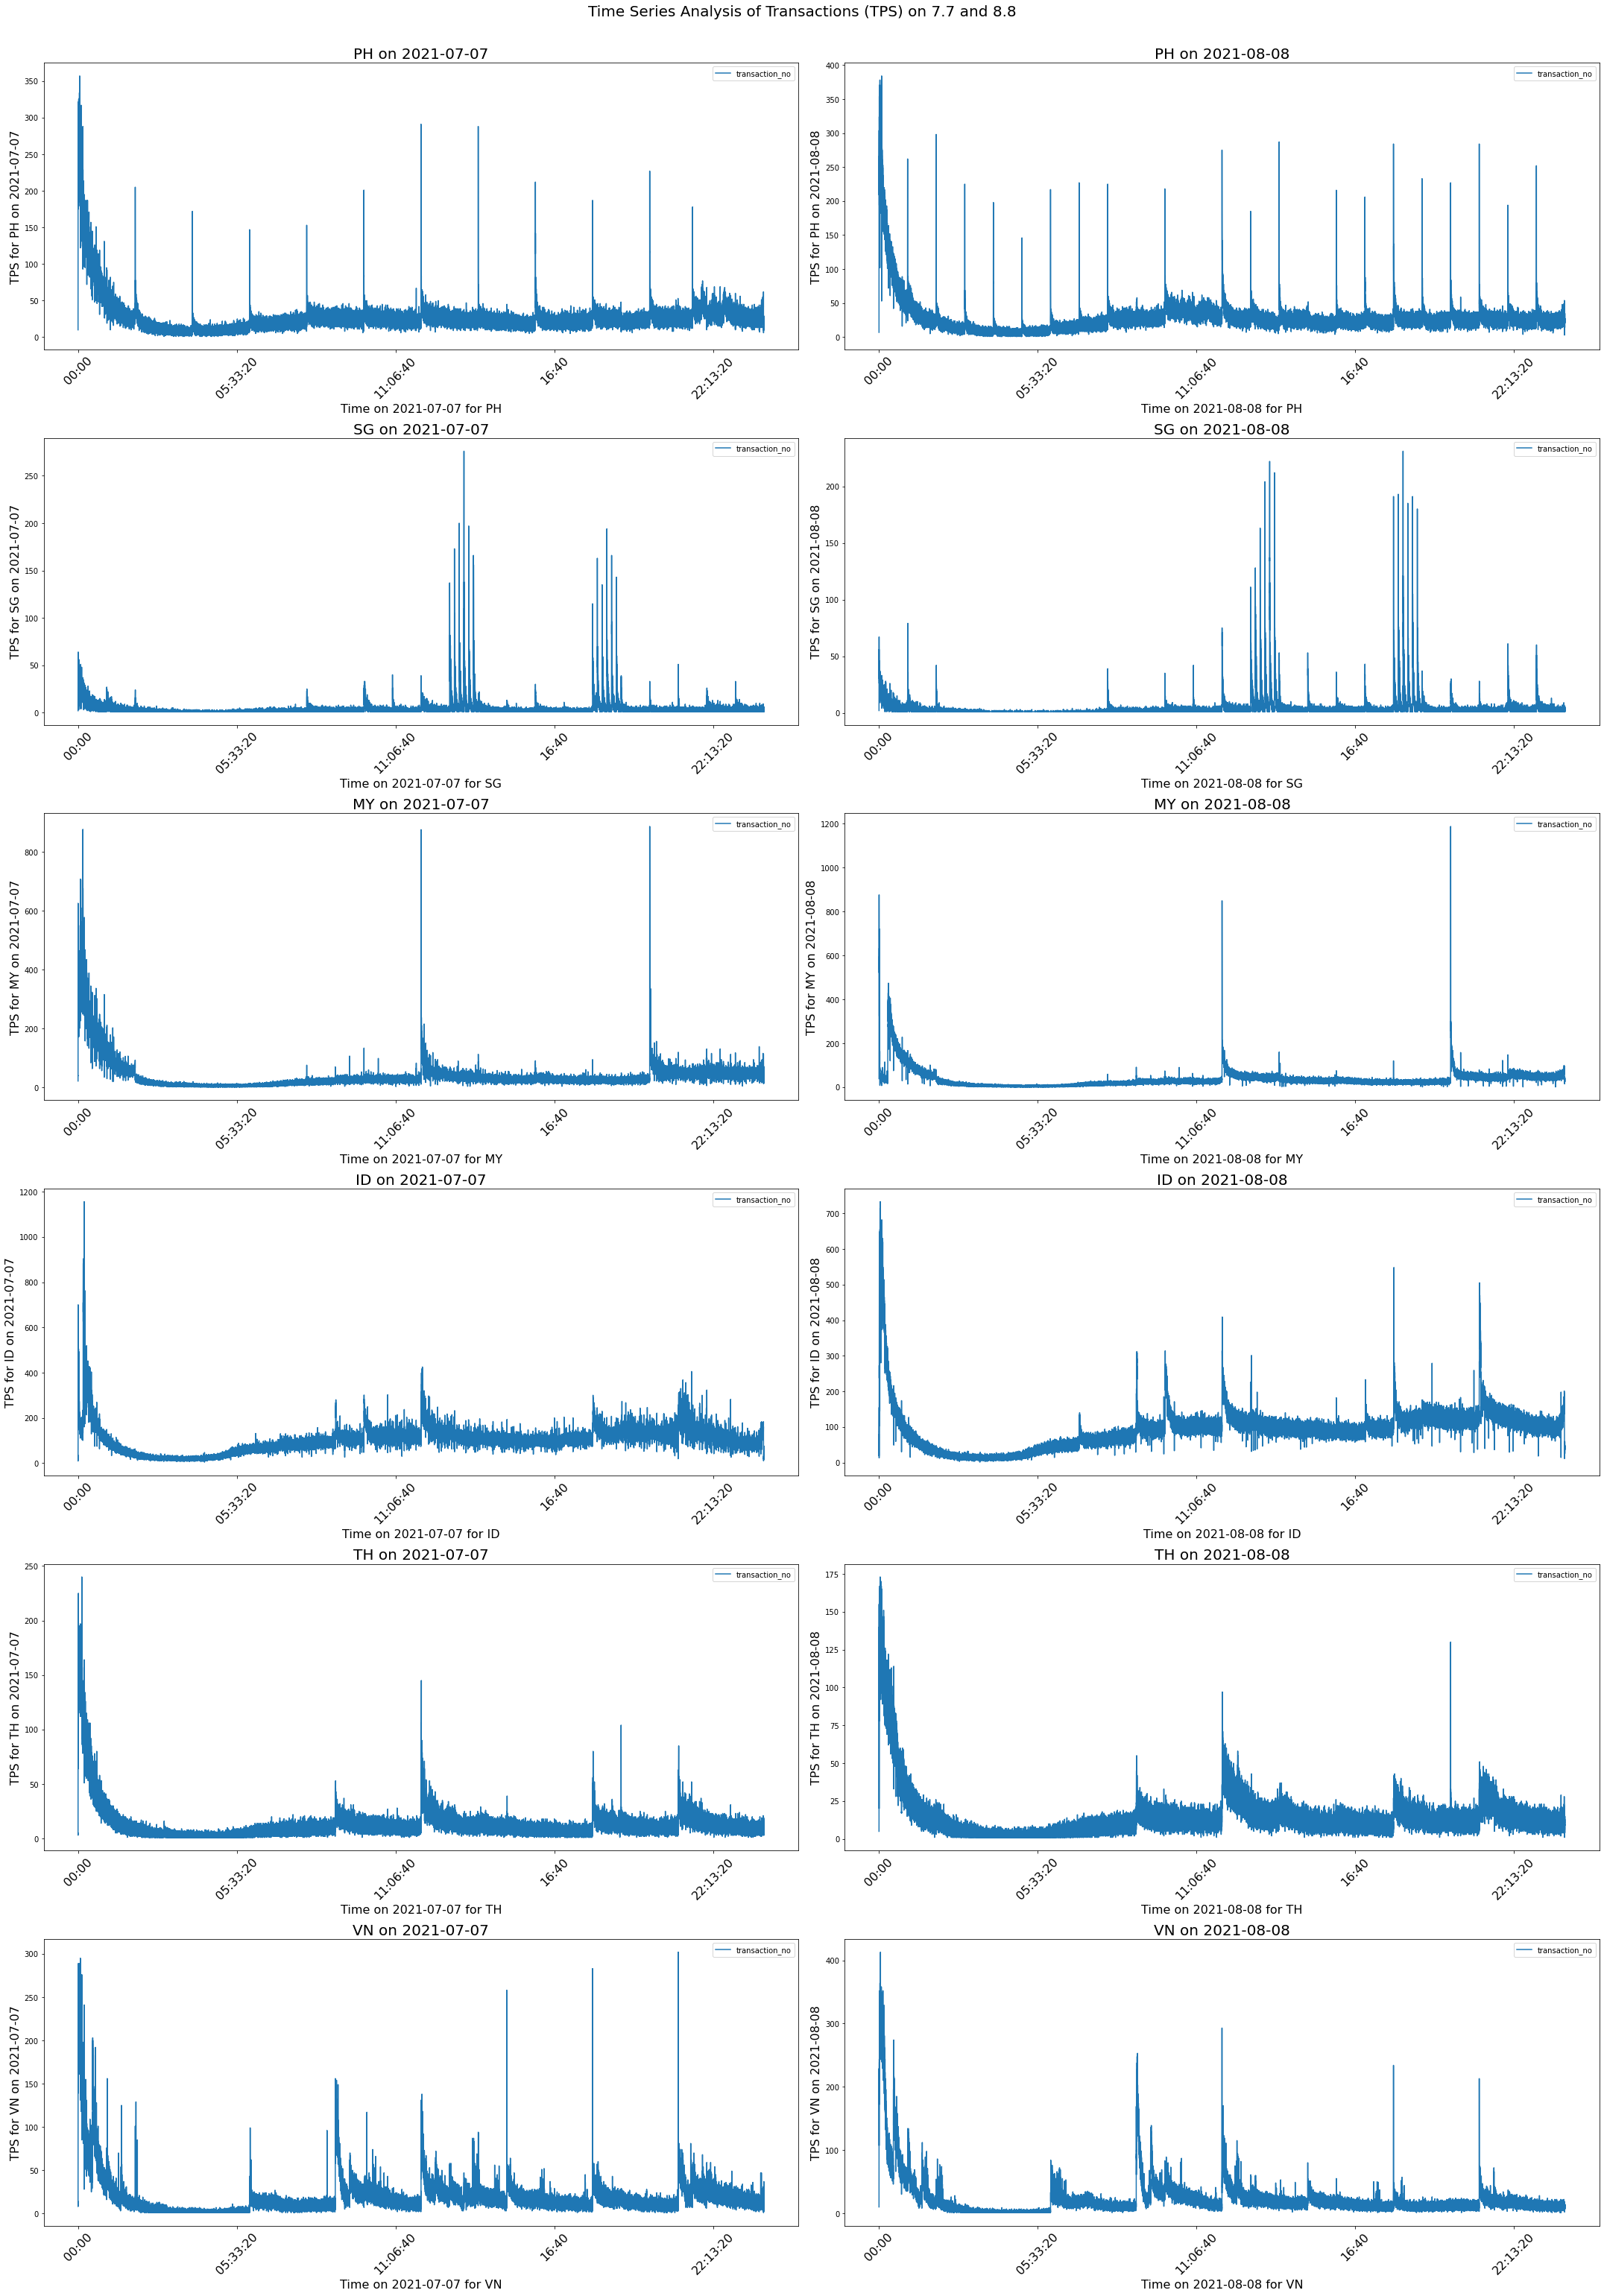

In [68]:
# Plot

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(6,2)


for i, country in enumerate(tuple(country_arr)):
    for j, date in enumerate(('2021-07-07', '2021-08-08')):
        
        df[(df['country']==country) & (df['date']==date)][['timestamp', 'transaction_no']].set_index('timestamp').\
            plot(figsize=(30,45), ax = ax[i,j])
        ax[i,j].set_ylabel(f'TPS for {country} on {date}', fontsize = 16)
        ax[i,j].set_xlabel(f'Time on {date} for {country}', fontsize = 16)
        ax[i,j].set_title(f'{country} on {date}', fontsize=20)
        ax[i,j].xaxis.set_tick_params(rotation = 45, labelsize=16)

fig.suptitle(f'Time Series Analysis of Transactions (TPS) on 7.7 and 8.8', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.975])

### 2./3./4. Payment changes history

In [21]:
%%time

# TPS

regions = {
    "PH": {"Timezone": 8, "Version": 1},
    "SG": {"Timezone": 8, "Version": 1},
    "MY": {"Timezone": 8, "Version": 2},
    "ID": {"Timezone": 7, "Version": 2},
    "TH": {"Timezone": 7, "Version": 2},
    "VN": {"Timezone": 7, "Version": 2}
} 

sdfArr = []

for k, v in regions.items():
    if v['Version'] == 1:
        tableVersionVariable = "_"
    elif v['Version'] == 2:
        tableVersionVariable = "_v2_"
    print(f'Working on: {k}')
    
    sqlFile = '''
    WITH base_table AS (
        SELECT  
            '{0}' AS country,
            b.channel_id,
            b.description AS channel_name, 
            (ctime + (({1}-8)*3600)) AS ctime, 
            from_unixtime(ctime + (({1}-8)*3600)) AS timestamp,
            CASE 
                WHEN old_status = 0 AND new_status = 2 THEN 'INIT_TO_PAYMENT_INIT'
                WHEN old_status = 2 AND new_status = 6 THEN 'PAYMENT_INIT_TO_USER_PROCESSING'
                WHEN old_status = 6 AND (
                    new_status = 17 
                    OR new_status = 20
                    OR new_status = 22
                    OR new_status = 24
                    OR new_status = 26
                    OR new_status = 39
                    OR new_status = 40
                    OR new_status = 50
                    OR new_status = 54
                    OR new_status = 100
                    OR new_status = 999
                ) THEN 'USER_PROCESSING_TO_SUCCESS_OR_FAILED'
            ELSE NULL END AS statusTag,
            COUNT(DISTINCT payment_id) AS pmt_count
        FROM shopee.shopee_payment_module_audit_{0}_db__payment_audit_tab a
        LEFT JOIN shopee.shopee_payment_module_{0}_db__payment_channel_tab b
        ON a.channel_id = b.channel_id
        WHERE 
            DATE(from_unixtime(ctime + (({1}-8)*3600))) IN (DATE('2021-07-07'), DATE('2021-08-08'))
            AND a.channel_id IN (8001400, 2001400, 4001400, 1001400, 7001800, 5001800)
        GROUP BY 1,2,3,4,5,6
    ), max_pmt AS (
        SELECT 
            country,
            DATE(from_unixtime(ctime)) AS date, 
            channel_id,
            channel_name,
            statusTag,
            MAX(pmt_count) AS max_pmt_count
        FROM base_table
        GROUP BY 1,2,3,4,5
    ), max_pmt_ts AS (
        SELECT 
            a.*, b.timestamp
        FROM max_pmt a 
        JOIN base_table b 
        ON 
            a.country = b.country 
            AND a.date = DATE(from_unixtime(b.ctime))
            AND a.channel_id = b.channel_id
            AND a.channel_name = b.channel_name
            AND a.statusTag = b.statusTag
            AND a.max_pmt_count = b.pmt_count
        ORDER BY date, statusTag
    )

    SELECT * FROM max_pmt_ts
    '''
    start_time = time.time()
    sqlFile = sqlFile.format(k, v['Timezone'], tableVersionVariable)
    sdf = spark.sql(sqlFile)
    sdf.cache()
    sdfArr.append(sdf)
    print(f'Query took: {time.time() - start_time} seconds.')
    
sdf_union = reduce(pyspark.sql.DataFrame.unionAll, sdfArr)
sdf_union.show()
sdf_union.toPandas().to_csv('payment_status_changes.csv', index=False)

Working on: PH
Query took: 1.1057438850402832 seconds.
Working on: SG
Query took: 0.8475131988525391 seconds.
Working on: MY
Query took: 0.568016767501831 seconds.
Working on: ID
Query took: 0.4207007884979248 seconds.
Working on: TH
Query took: 0.4332253932952881 seconds.
Working on: VN
Query took: 0.41858434677124023 seconds.
+-------+----------+----------+-------------------+--------------------+-------------+-------------------+
|country|      date|channel_id|       channel_name|           statusTag|max_pmt_count|          timestamp|
+-------+----------+----------+-------------------+--------------------+-------------+-------------------+
|     PH|2021-07-07|   4001400|Shopee Wallet V2 PH|INIT_TO_PAYMENT_INIT|          343|2021-07-07 00:02:55|
|     PH|2021-07-07|   4001400|Shopee Wallet V2 PH|PAYMENT_INIT_TO_U...|          327|2021-07-07 00:02:39|
|     PH|2021-07-07|   4001400|Shopee Wallet V2 PH|USER_PROCESSING_T...|          325|2021-07-07 00:03:21|
|     PH|2021-08-08|   40014

In [3]:
%%time

# TPS - Validating VN and TH

regions = {
#     "PH": {"Timezone": 8, "Version": 1},
#     "SG": {"Timezone": 8, "Version": 1},
#     "MY": {"Timezone": 8, "Version": 2},
#     "ID": {"Timezone": 7, "Version": 2},
    "TH": {"Timezone": 7, "Version": 2},
    "VN": {"Timezone": 7, "Version": 2}
} 

sdfArr = []

for k, v in regions.items():
    if v['Version'] == 1:
        tableVersionVariable = "_"
    elif v['Version'] == 2:
        tableVersionVariable = "_v2_"
    print(f'Working on: {k}')
    
    sqlFile = '''
    WITH base_table AS (
        SELECT  
            '{0}' AS country,
            b.channel_id,
            b.description AS channel_name, 
            (ctime + (({1}-8)*3600)) AS ctime, 
            from_unixtime(ctime + (({1}-8)*3600)) AS timestamp,
            CASE 
                WHEN old_status = 0 AND new_status = 2 THEN 'INIT_TO_PAYMENT_INIT'
                WHEN old_status = 2 AND new_status = 6 THEN 'PAYMENT_INIT_TO_USER_PROCESSING'
                WHEN old_status = 6 AND (
                    new_status = 17 
                    OR new_status = 20
                    OR new_status = 22
                    OR new_status = 24
                    OR new_status = 26
                    OR new_status = 39
                    OR new_status = 40
                    OR new_status = 50
                    OR new_status = 54
                    OR new_status = 100
                    OR new_status = 999
                ) THEN 'USER_PROCESSING_TO_SUCCESS_OR_FAILED'
            ELSE NULL END AS statusTag,
            COUNT(DISTINCT payment_id) AS pmt_count
        FROM shopee.shopee_payment_module_audit_{0}_db__payment_audit_tab a
        LEFT JOIN shopee.shopee_payment_module_{0}_db__payment_channel_tab b
        ON a.channel_id = b.channel_id
        WHERE 
            DATE(from_unixtime(ctime + (({1}-8)*3600))) IN (DATE('2021-07-07'), DATE('2021-08-08'))
            AND a.channel_id IN (8001400, 2001400, 4001400, 1001400, 7001800, 5001800)
        GROUP BY 1,2,3,4,5,6
    ), max_pmt AS (
        SELECT 
            country,
            DATE(from_unixtime(ctime)) AS date, 
            channel_id,
            channel_name,
            statusTag,
            MAX(pmt_count) AS max_pmt_count
        FROM base_table
        GROUP BY 1,2,3,4,5
    ), max_pmt_ts AS (
        SELECT 
            a.*, b.timestamp
        FROM max_pmt a 
        JOIN base_table b 
        ON 
            a.country = b.country 
            AND a.date = DATE(from_unixtime(b.ctime))
            AND a.channel_id = b.channel_id
            AND a.channel_name = b.channel_name
            AND a.statusTag = b.statusTag
            AND a.max_pmt_count = b.pmt_count
        ORDER BY date, statusTag
    )

    SELECT * FROM max_pmt_ts
    '''
    start_time = time.time()
    sqlFile = sqlFile.format(k, v['Timezone'], tableVersionVariable)
    sdf = spark.sql(sqlFile)
    sdf.cache()
    sdfArr.append(sdf)
    print(f'Query took: {time.time() - start_time} seconds.')
    
sdf_union = reduce(pyspark.sql.DataFrame.unionAll, sdfArr)
sdf_union.show()
sdf_union.toPandas().to_csv('payment_status_changes_thAndVn.csv', index=False)

Working on: TH
Query took: 6.869082450866699 seconds.
Working on: VN
Query took: 1.3591864109039307 seconds.
+-------+----------+----------+----------------+--------------------+-------------+-------------------+
|country|      date|channel_id|    channel_name|           statusTag|max_pmt_count|          timestamp|
+-------+----------+----------+----------------+--------------------+-------------+-------------------+
|     TH|2021-07-07|   7001800|Airpay Wallet V2|INIT_TO_PAYMENT_INIT|          201|2021-07-07 00:00:54|
|     TH|2021-08-08|   7001800|Airpay Wallet V2|INIT_TO_PAYMENT_INIT|          174|2021-08-08 00:01:32|
|     VN|2021-07-07|   5001800|Airpay Wallet V2|INIT_TO_PAYMENT_INIT|          285|2021-07-07 00:02:33|
|     VN|2021-08-08|   5001800|Airpay Wallet V2|INIT_TO_PAYMENT_INIT|          398|2021-08-08 00:03:06|
+-------+----------+----------+----------------+--------------------+-------------+-------------------+

CPU times: user 63.5 ms, sys: 16.5 ms, total: 80.1 ms
Wall